<a href="https://colab.research.google.com/github/EzequielAssis/Evapotranspiration_Interpolation/blob/main/ETo_Interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**<font color='green'>Obtenção da variável Evapotranspiração de Referência (ETo)</font>**

##Instalações necessárias

In [1]:
!pip install refet
!pip install geopandas
!pip install rasterio
!pip install rtree
!pip install pykrige
!pip install pygeos
!brew install spatialindex
!git clone https://github.com/EzequielAssis/Shapefiles.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for refet: filename=refet-0.3.10-py3-none-any.whl size=18503 sha256=076c5c204ac7f5d5409da724dd968a2841db8b248f29b607fa92a2334d53a55e
  Stored in directory: /root/.cache/pip/wheels/23/50/54/9095f73a47ad462edae51aa56b6a3b0631e6fb36180d13b5c9
Successfully built refet
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.6 MB/s 
     |████████████████████████████████| 16.7 MB 267 kB/s 
     |████████████████████████████████| 6.3 MB 38.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 54.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
Looking in indexes: https://pypi.o

##Importação de bibliotecas

In [2]:
import requests
import json
import pandas as pd
import numpy as np
import math
from math import pi, sin, cos, tan, acos
import refet
import matplotlib.pyplot as plt
import geopandas as gpd
import copy
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from pykrige import OrdinaryKriging
from pykrige import OrdinaryKriging3D
from sklearn import metrics
from random import random as rd

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


##Acessando API do INMET e extraindo as colunas de interesse

In [3]:
import datetime

def datestdtojd(stddate):
    fmt='%Y-%m-%d'
    sdtdate = datetime.datetime.strptime(stddate, fmt)
    sdtdate = sdtdate.timetuple()
    jdate = sdtdate.tm_yday
    return jdate

day = '2020-09-24'
julian_day = datestdtojd(day)

In [4]:
#Acessando a API do INMET e do IBGE (IBGE -> UFs do nordeste)
auto_stations = requests.get(f'https://apitempo.inmet.gov.br/estacao/dados/{day}')
resp_metadata = requests.get('https://apitempo.inmet.gov.br/estacoes/T')
resp_region = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/regioes/2/estados')
df_aut_stt = pd.DataFrame(auto_stations.json())
metadata_df = pd.DataFrame(resp_metadata.json())
df_ndt = pd.DataFrame(resp_region.json())

In [5]:
display(df_aut_stt.head(5))

,VEN_DIR,DT_MEDICAO,DC_NOME,CHUVA,PRE_INS,VL_LATITUDE,PRE_MIN,UMD_MAX,PRE_MAX,VEN_VEL,...,PTO_INS,VEN_RAJ,TEM_INS,UMD_INS,CD_ESTACAO,TEM_MIN,VL_LONGITUDE,HR_MEDICAO,UMD_MIN,PTO_MAX
0,131,2020-09-24,BRASILIA,0,890.7,-15.78944444,890.7,84,890.9,2,...,17,3.6,19.9,84,A001,19.9,-47.92583332,0000,80,17
1,135,2020-09-24,BRASILIA,0,891,-15.78944444,890.7,86,891,3,...,17,4.8,19.3,86,A001,19.3,-47.92583332,0100,84,17.1
2,142,2020-09-24,BRASILIA,0,891.5,-15.78944444,891,87,891.6,3.1,...,16.4,5,18.7,86,A001,18.7,-47.92583332,0200,86,17
3,125,2020-09-24,BRASILIA,0,891.3,-15.78944444,891.3,87,891.6,3,...,16.2,5.5,18.4,87,A001,18.4,-47.92583332,0300,86,16.4
4,132,2020-09-24,BRASILIA,0,890.9,-15.78944444,890.9,88,891.5,2.5,...,16,6.1,18,88,A001,18,-47.92583332,0400,87,16.2


In [6]:
#Filtrando os dados de interesse e armazenando no DataFrame filter_df
data = ['TEM_MAX', 'TEM_MIN', 'PTO_INS', 'RAD_GLO', 'VEN_VEL']
metadata = [ 'VL_ALTITUDE', 'VL_LATITUDE', 'VL_LONGITUDE', 'DC_NOME', 'UF', 'CD_ESTACAO']
#metadata_df['SG_ESTADO'].isin(list(df_ndt['sigla']))
#metadata_df['SG_ESTADO'] == 'PE'
alt_df = metadata_df.loc[metadata_df['SG_ESTADO'].isin(list(df_ndt['sigla'])), ['VL_ALTITUDE', 'CD_ESTACAO']]
display(alt_df)
#df_aut_stt['UF'].isin(list(df_ndt['sigla']))
#df_aut_stt['UF'] == 'PE'
filter_df = df_aut_stt.loc[df_aut_stt['UF'].isin(list(df_ndt['sigla'])), data + metadata[1:]]
display(filter_df)

,VL_ALTITUDE,CD_ESTACAO
0,20.93,A422
1,67.15,A360
17,283.69,A223
19,261.26,A336
21,397.8,A434
...,...,...
566,398.83,A346
571,93.12,A444
572,313.39,A363
582,879.38,A414


,TEM_MAX,TEM_MIN,PTO_INS,RAD_GLO,VEN_VEL,VL_LATITUDE,VL_LONGITUDE,DC_NOME,UF,CD_ESTACAO
2041,26.5,26.1,21.8,0.509,2.7,-2.52666666,-44.21361111,SÃO LUIS,MA,A203
2042,26.1,25.9,21.9,0.751,1.4,-2.52666666,-44.21361111,SÃO LUIS,MA,A203
2043,25.9,25.6,21.8,0.794,1.4,-2.52666666,-44.21361111,SÃO LUIS,MA,A203
2044,25.8,25.6,22,0.527,1.8,-2.52666666,-44.21361111,SÃO LUIS,MA,A203
2045,25.7,25.5,22.5,-0.413,1.4,-2.52666666,-44.21361111,SÃO LUIS,MA,A203
...,...,...,...,...,...,...,...,...,...,...
6548,None,None,None,None,None,-11.05861111,-38.44416666,RIBEIRA DO AMPARO,BA,A458
6549,None,None,None,None,None,-11.05861111,-38.44416666,RIBEIRA DO AMPARO,BA,A458
6550,None,None,None,None,None,-11.05861111,-38.44416666,RIBEIRA DO AMPARO,BA,A458
6551,None,None,None,None,None,-11.05861111,-38.44416666,RIBEIRA DO AMPARO,BA,A458


###String ==> Float 

In [7]:
#convertendo os dados das 6 primeiras colunas para o tipo float
sub_df = filter_df[data+metadata[1:3]].astype(float)
#contatena os dados float (sub_set) com os metadados que são do tipo str
sub_df = pd.concat([sub_df, filter_df[metadata[3:]]], axis=1)
sub_df.RAD_GLO.mask(sub_df.RAD_GLO < 0, 0, inplace=True)
display(sub_df)
print(sub_df.dtypes)

,TEM_MAX,TEM_MIN,PTO_INS,RAD_GLO,VEN_VEL,VL_LATITUDE,VL_LONGITUDE,DC_NOME,UF,CD_ESTACAO
2041,26.5,26.1,21.8,0.509,2.7,-2.526667,-44.213611,SÃO LUIS,MA,A203
2042,26.1,25.9,21.9,0.751,1.4,-2.526667,-44.213611,SÃO LUIS,MA,A203
2043,25.9,25.6,21.8,0.794,1.4,-2.526667,-44.213611,SÃO LUIS,MA,A203
2044,25.8,25.6,22.0,0.527,1.8,-2.526667,-44.213611,SÃO LUIS,MA,A203
2045,25.7,25.5,22.5,0.000,1.4,-2.526667,-44.213611,SÃO LUIS,MA,A203
...,...,...,...,...,...,...,...,...,...,...
6548,NaN,NaN,NaN,NaN,NaN,-11.058611,-38.444167,RIBEIRA DO AMPARO,BA,A458
6549,NaN,NaN,NaN,NaN,NaN,-11.058611,-38.444167,RIBEIRA DO AMPARO,BA,A458
6550,NaN,NaN,NaN,NaN,NaN,-11.058611,-38.444167,RIBEIRA DO AMPARO,BA,A458
6551,NaN,NaN,NaN,NaN,NaN,-11.058611,-38.444167,RIBEIRA DO AMPARO,BA,A458


TEM_MAX         float64
TEM_MIN         float64
PTO_INS         float64
RAD_GLO         float64
VEN_VEL         float64
VL_LATITUDE     float64
VL_LONGITUDE    float64
DC_NOME          object
UF               object
CD_ESTACAO       object
dtype: object


##Manipulação dos dados
* Encontrar altitudes das estações.
* Remover estações inválidas (colunas NaN, altitude não encontrada)
* Converter de horário para diário.


In [8]:
#cria um lista de estações para fazer o acesso de cada estação dentro do loop for
list_stations = list(sub_df['CD_ESTACAO'].drop_duplicates())

list_daily = []
list_rm = []

for station in list_stations:

    var_daily = []

    #extrai os 24 registros da estação que está sendo acessada na lista list_stations
    df_station = sub_df.loc[sub_df['CD_ESTACAO'] == station]
    df_station_td = df_station.loc[:, data]

    metadata_stt = list(df_station.iloc[0, df_station.columns.get_indexer(metadata[1:])])

    #Encontrar Altitude de cada estação
    altitude_df = alt_df.loc[alt_df['CD_ESTACAO'] == station, ['VL_ALTITUDE']].astype(float)
    if altitude_df.empty:
        metadata_stt.insert(0, None)
    else:
        metadata_stt.insert(0, altitude_df.iat[0,0])

    #verifica se a atual estação contêm valores desconhecidos (NaN,...)
    #ou se a altitude não foi encontrada
    #if not df_station_td.isnull().all().any() or (not df_station_td.isnull().all().any() and metadata_stt[0] == None):
    if df_station_td.isnull().all().any() or metadata_stt[0] == None:
        #estação contém ao menos uma coluna com todos os valores nulos
        list_rm.append(metadata_stt)
    else:
        #estação é válida, logo é feita a conversão horária para diária
        df_station_td[['VEN_VEL', 'PTO_INS']] = df_station_td[['VEN_VEL', 'PTO_INS']].fillna(-1)
        wind_spd_mean = df_station_td.loc[df_station_td['VEN_VEL'] >= 0, ['VEN_VEL']].mean()
        pto_ins_mean = df_station_td.loc[df_station_td['PTO_INS'] >= 0, ['PTO_INS']].mean()
        var_daily.append(df_station_td['TEM_MAX'].max())
        var_daily.append(df_station_td['TEM_MIN'].min())
        var_daily.append(pto_ins_mean[0])
        var_daily.append(df_station_td['RAD_GLO'].sum())
        var_daily.append(wind_spd_mean[0])
        
        #list_daily recebe um lista com os dados convertidos e metadados de uma estação
        list_daily.append(var_daily + metadata_stt)

df_daily = pd.DataFrame(data=list_daily, columns = data + metadata)
rm_stations = pd.DataFrame(data=list_rm, columns=metadata)
#converte Rad. Solar de KJ/m² para MJ/m²
df_daily.RAD_GLO = df_daily.RAD_GLO/1E3

display(df_daily)
print('\n\n',' '*20, 'ESTAÇÕES REMOVIDAS\n')
display(rm_stations)
print(f'\n\nDe {len(list_stations)} estações analisadas, {rm_stations.shape[0]} ', end='')
print('foram removidas por apresentarem dados NAN')
print()
print('Em relação a condição para ser removida, basta que a estação ', end='')
print(' apresente ao menos uma coluna completa de dados Nulos.')
print()
display(df_daily.dtypes)

,TEM_MAX,TEM_MIN,PTO_INS,RAD_GLO,VEN_VEL,VL_ALTITUDE,VL_LATITUDE,VL_LONGITUDE,DC_NOME,UF,CD_ESTACAO
0,32.2,24.7,22.220833,0.008596,2.683333,54.80,-2.526667,-44.213611,SÃO LUIS,MA,A203
1,38.3,24.9,19.166667,21.467123,1.608333,182.88,-7.337222,-47.459722,CAROLINA,MA,A205
2,36.3,23.7,20.725000,22.880478,1.300000,22.33,-4.243056,-44.795000,BACABAL,MA,A220
3,37.3,26.6,18.206667,21.520887,2.133333,154.19,-5.506667,-45.236944,BARRA DO CORDA,MA,A221
4,39.1,23.6,14.838095,18.239762,1.766667,175.37,-6.033056,-44.233333,COLINAS,MA,A222
...,...,...,...,...,...,...,...,...,...,...,...
92,34.2,23.6,19.050000,26.410173,3.183333,385.00,-10.018333,-42.500278,PILAO ARCADO,BA,A449
93,31.8,18.0,16.161905,24.734815,2.704167,261.00,-10.080833,-38.345833,JEREMOABO,BA,A450
94,37.8,20.1,15.820000,19.915258,2.037500,488.00,-11.052222,-45.200833,FORMOSA DO RIO PRETO,BA,A452
95,28.1,19.6,20.080000,16.180675,2.586667,110.00,-17.006944,-39.558056,ITAMARAJU,BA,A455




                      ESTAÇÕES REMOVIDAS



,VL_ALTITUDE,VL_LATITUDE,VL_LONGITUDE,DC_NOME,UF,CD_ESTACAO
0,271.03,-7.455556,-46.027500,BALSAS,MA,A204
1,104.00,-3.742778,-43.352222,CHAPADINHA,MA,A206
2,232.29,-5.816111,-46.162222,GRAJAÚ,MA,A207
3,9.87,-2.270833,-43.624167,FAROL de SANTANA,MA,A217
4,4.62,-2.592222,-42.707500,PREGUIÇAS,MA,A218
5,35.86,-1.661111,-45.372500,TURIAÇU,MA,A219
6,84.85,-4.821389,-43.343611,CAXIAS,MA,A237
7,174.91,-4.320556,-46.449444,BURITICUPÚ,MA,A238
8,45.50,-3.269167,-45.651111,ZE DOCA,MA,A255
9,11.30,-8.059167,-34.959167,RECIFE,PE,A301




De 151 estações analisadas, 54 foram removidas por apresentarem dados NAN

Em relação a condição para ser removida, basta que a estação  apresente ao menos uma coluna completa de dados Nulos.



TEM_MAX         float64
TEM_MIN         float64
PTO_INS         float64
RAD_GLO         float64
VEN_VEL         float64
VL_ALTITUDE     float64
VL_LATITUDE     float64
VL_LONGITUDE    float64
DC_NOME          object
UF               object
CD_ESTACAO       object
dtype: object

##Validação dos dados

####Cálculo do Ra

In [9]:
def ext_radiation(j_day, latitude):
    '''
    Função que calcula a irradiação solar extraterrestre
    ext_radiation(j_day, latitude)

    j_day: dia juliano
    latitude: latitude da estação
    '''
    SOLAR_CONST = 0.082 #MJ m-2 min-1

    lr = lat_rad(latitude)
    dr = inv_rel_distance(j_day)
    sd = solar_declination(j_day)
    ws = sh_angle(lr, sd)
    Ra = ((24*60)/pi) * SOLAR_CONST * dr * (ws*sin(lr)*sin(sd) + cos(lr)*cos(sd)*sin(ws))
    return Ra #extraterrestrial radiation [MJ m-2 day-1]

def lat_rad(lat):
    lr = (pi/180)*lat
    return lr

def inv_rel_distance(jul_day):
    dr = 1 + 0.033*cos((2*pi*jul_day)/365) #inverse relative distance Earth-Sun
    return dr

def solar_declination(jul_day):
    sd = 0.409*sin(((2*pi/365)*jul_day) - 1.39)
    return sd

def sh_angle(lr, sd):
    ws = acos(-tan(lr)*tan(sd))
    return ws


#Determination of extraterrestrial radiation (EXEMPLO 8 do FA56, Pg 47)
#Ra_day = ext_radiation(246, -20)
#print(f'extraterrestrial radiation = {Ra_day:.1f} [MJ m-2 day-1]')

####Remover estações com variáveis fora dos intervalos especificados

In [10]:
list_drop = []
#validação da radiação
for stt in range(df_daily.shape[0]):
    latitude = df_daily.iat[stt, 6]
    Ra_day = ext_radiation(julian_day, latitude)
    if (df_daily.iat[stt, 3] > Ra_day) or (df_daily.iat[stt, 3] <= Ra_day * 0.003):
        #armazenando as estações que não passaram na validação da radiação solar
        list_drop.append(stt)
df_daily = df_daily.drop(index=list_drop)
#validação da temperatura maxima
df_daily = df_daily.loc[df_daily['TEM_MAX'] <= 50]
df_daily = df_daily.loc[df_daily['TEM_MAX'] > -30]
#validação da temperatura minima
df_daily = df_daily.loc[df_daily['TEM_MIN'] <= 50]
df_daily = df_daily.loc[df_daily['TEM_MIN'] > -30]
#validação do ponto de orvalho
df_daily = df_daily.loc[df_daily['PTO_INS'] <= 50]
df_daily = df_daily.loc[df_daily['PTO_INS'] > -30]
#validação da velocidade do vento
df_daily = df_daily.loc[df_daily['VEN_VEL'] <= 100]
df_daily = df_daily.loc[df_daily['VEN_VEL'] > 0]

df_daily.index = list(range(df_daily.shape[0]))
display(df_daily)

,TEM_MAX,TEM_MIN,PTO_INS,RAD_GLO,VEN_VEL,VL_ALTITUDE,VL_LATITUDE,VL_LONGITUDE,DC_NOME,UF,CD_ESTACAO
0,38.3,24.9,19.166667,21.467123,1.608333,182.88,-7.337222,-47.459722,CAROLINA,MA,A205
1,36.3,23.7,20.725000,22.880478,1.300000,22.33,-4.243056,-44.795000,BACABAL,MA,A220
2,37.3,26.6,18.206667,21.520887,2.133333,154.19,-5.506667,-45.236944,BARRA DO CORDA,MA,A221
3,39.1,23.6,14.838095,18.239762,1.766667,175.37,-6.033056,-44.233333,COLINAS,MA,A222
4,37.6,23.1,14.850000,22.683360,1.175000,283.69,-9.108333,-45.931944,ALTO PARNAÍBA,MA,A223
...,...,...,...,...,...,...,...,...,...,...,...
90,34.2,23.6,19.050000,26.410173,3.183333,385.00,-10.018333,-42.500278,PILAO ARCADO,BA,A449
91,31.8,18.0,16.161905,24.734815,2.704167,261.00,-10.080833,-38.345833,JEREMOABO,BA,A450
92,37.8,20.1,15.820000,19.915258,2.037500,488.00,-11.052222,-45.200833,FORMOSA DO RIO PRETO,BA,A452
93,28.1,19.6,20.080000,16.180675,2.586667,110.00,-17.006944,-39.558056,ITAMARAJU,BA,A455


##Cálculo da evapotranspiração usando a biblioteca Refet

In [11]:
data_np = df_daily[data + metadata[:2]].values
#display(data_np)
list_eto = []

for stt in range(data_np.shape[0]):

    #Compute actual vapor pressure from Tdew
    tdew_c = data_np[stt, 2]
    ea = 0.6108 * math.exp(17.27 * tdew_c / (tdew_c + 237.3))  # kPa
    #ea = refet.calcs._saturated_vapor_pressure(tdew_c)

    eto = refet.Daily(
        tmin=data_np[stt, 1], tmax=data_np[stt, 0], ea=ea, rs=data_np[stt, 3], uz=data_np[stt, 4], 
        zw=2, elev=data_np[stt, 5], lat=data_np[stt, 6], doy=julian_day, method='asce',
        input_units={'tmin': 'C', 'tmax': 'C', 'rs': 'MJ m-2 day-1', 'uz': 'm s-1', 'lat': 'deg'}
        ).eto()

    list_eto.append(eto)

df_eto = pd.DataFrame(data=list_eto, columns=['ETo'])
df = pd.concat([df_eto, df_daily[metadata]], axis=1)
df

,ETo,VL_ALTITUDE,VL_LATITUDE,VL_LONGITUDE,DC_NOME,UF,CD_ESTACAO
0,6.083241,182.88,-7.337222,-47.459722,CAROLINA,MA,A205
1,5.599896,22.33,-4.243056,-44.795000,BACABAL,MA,A220
2,6.698206,154.19,-5.506667,-45.236944,BARRA DO CORDA,MA,A221
3,6.155690,175.37,-6.033056,-44.233333,COLINAS,MA,A222
4,5.747425,283.69,-9.108333,-45.931944,ALTO PARNAÍBA,MA,A223
...,...,...,...,...,...,...,...
90,7.226763,385.00,-10.018333,-42.500278,PILAO ARCADO,BA,A449
91,6.097976,261.00,-10.080833,-38.345833,JEREMOABO,BA,A450
92,6.248547,488.00,-11.052222,-45.200833,FORMOSA DO RIO PRETO,BA,A452
93,3.661983,110.00,-17.006944,-39.558056,ITAMARAJU,BA,A455


In [12]:
#df.to_csv(f'/content/eto_nordeste_{day}.csv', index=None)

##Leitura do shapefile

In [13]:
##PERNAMBUCO (remove-se Fernando de Noronha do shapefile)
#br_shp = gpd.read_file('/content/Shapefiles/PE-MUN/26MUE250GC_SIR.shp')
##Removendo Fernando de Noronha para melhor visualização do estado
#rm_fn = br_shp.loc[br_shp['NM_MUNICIP'] == 'FERNANDO DE NORONHA'].index.values
#shp = br_shp.drop(labels=rm_fn)

In [14]:
##Qualquer estado do Brasil
#br_shp = gpd.read_file('/content/Shapefiles/Brasil/UFEBRASIL.shp')
#br_shp['ID'] = [x for x in range(br_shp.shape[0])]
#print('ESCOLHA DO ESTADO POR MEIO DO INDEX\n\n')
#display(br_shp[['ID', 'NM_ESTADO']])
#index = 16
#shp = br_shp.loc[[index]]

In [15]:
##BRASIL
#as_shp = gpd.read_file('/content/Shapefiles/shapefile_país/pais.shp')
#shp = as_shp.loc[as_shp['NOME'] == 'BRASIL']
#shp

In [16]:
#Regiões do Brasil
re_shp = gpd.read_file('/content/Shapefiles/regioes_do_Brasil/regioes_2010.shp')
shp = re_shp.loc[re_shp['nome'] == 'Nordeste']
shp

,id,nome,sigla,geometry
3,4,Nordeste,NE,"MULTIPOLYGON (((-35.15204 -8.91295, -35.15366 ..."


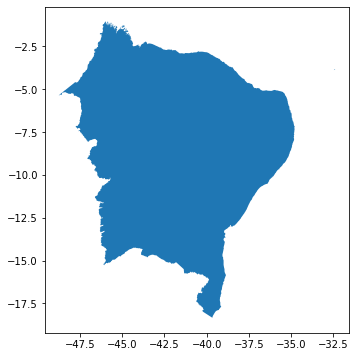

In [17]:
fig, ax = plt.subplots(figsize=(6,6))
shp.plot(ax=ax)

In [18]:
#A máxima e mínima de latitude e longitude
xmin, ymin, xmax, ymax = shp.total_bounds

xmin = xmin-0.05

#Ajustado em -2 para corrigir a longitude do lado direito
#Usar +0.05 na leitura de outros  shapefiles
xmax = xmax-2

ymin = ymin-0.05
ymax = ymax+0.05

size = 200

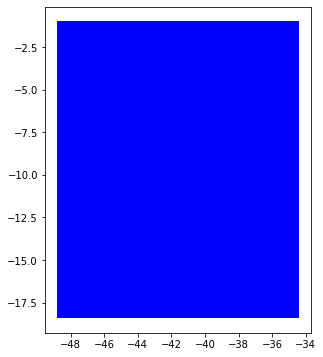

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
#Cria um shapefile retangular a paritr dos limites do shp acima
from shapely.geometry import Polygon

lat_point = [ymin, ymin, ymax, ymax]
lon_point = [xmin, xmax, xmax, xmin]

polygon_geom = Polygon(zip(lon_point, lat_point))

crs = shp.crs #
polygon_retang = gpd.GeoDataFrame(geometry=[polygon_geom], crs=crs)

polygon_retang.plot(figsize=(6,6), color='blue')
plt.show()
display(crs)

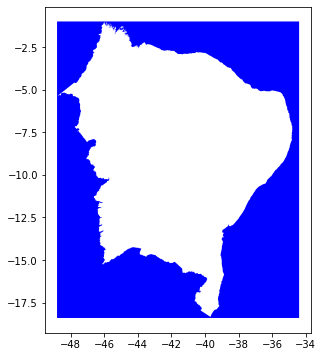

In [20]:
#"Recorta" o shapefile lido dentro do shapefile retangular criado
shp_cut = polygon_retang.overlay(shp, how="difference")
shp_cut.plot(figsize=(6,6), color='blue', alpha=1)
plt.show()

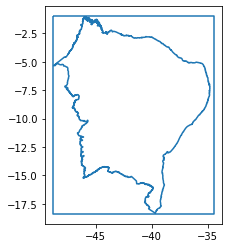

In [21]:
#Cria umm shapefile de linhas
shp_bound = shp_cut.boundary
shp_bound.plot()

In [22]:
display(xmin, ymin, xmax, ymax)

-48.80471282282593

-18.398743440010595

-34.39087522629802

-0.9950854229755668

##Pontos de ETo

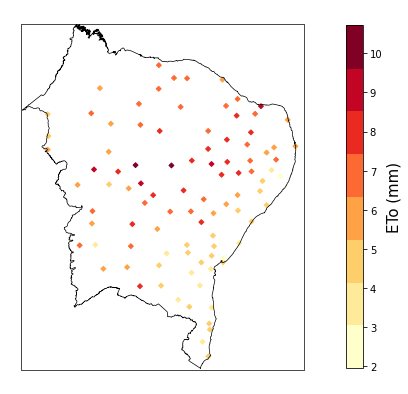

In [77]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
import geopandas as gpd


fig, ax = plt.subplots(figsize=(10,7))
shp_bound.plot(ax=ax, color='black', alpha = 1, linewidth=0.7, zorder = 2)
plt.rcParams['axes.facecolor']='white'
# Add info from DataFrame
main_var = 'ETo'

cs = plt.scatter(df['VL_LONGITUDE'].values, df['VL_LATITUDE'].values,\
     c=df[main_var].values, cmap=plt.get_cmap('YlOrRd', 8),\
     marker='D', s=12, alpha=1, vmin=df[main_var].min(), vmax=df[main_var].max())

plt.colorbar(cs, shrink=0.9).set_label(main_var+' (mm)', fontsize=15)
#cbar.set_ticks(np.around(np.linspace(3.2, 10.4, 9), 1), True)
plt.xticks(fontsize = 10, rotation=60)
plt.yticks(fontsize = 10)
ax.axis('off')
plt.show()

#**<font color='green'>Interpolação da ETo</font>**
* Ordinary Kriging
* Inverse Distance Weighting
* Random Forest


In [24]:
df_y_pred = pd.DataFrame()
size = 200
grid_lon = np.linspace(xmin, xmax, size)
grid_lat = np.linspace(ymin, ymax, size)

xintrp, yintrp = np.meshgrid(grid_lon, grid_lat)

coor_x = np.reshape(xintrp, -1)
coor_y = np.reshape(yintrp, -1)
df_coord = pd.DataFrame({'VL_LONGITUDE': coor_x, 'VL_LATITUDE': coor_y})

#extraindo latitude, longitude e ETo das estações
X = df[['VL_LONGITUDE', 'VL_LATITUDE']].values
y = df[['ETo']].values.reshape(-1)

In [37]:
def predict_eto(name_interp, X, y, gridlln):
    interpoladores = [RandomForestRegressor(n_estimators=500),
                      KNeighborsRegressor(n_neighbors=5, weights='distance')]
    list_interp = ['RF',
                   'IDW']

    if 'OK' in name_interp:
        if X.shape[1] == 2:
            z1, _ = OrdinaryKriging(X[:,0], X[:,1], y, variogram_model='exponential', verbose=False,\
                        enable_plotting=False,nlags=20).execute('points', gridlln[:,0], gridlln[:,1])
        else:
            z1, _ = OrdinaryKriging3D(X[:,0], X[:,1], X[:,2], y, variogram_model='exponential', verbose=False,\
                                      enable_plotting=False,nlags=20).execute('points', gridlln[:,0], gridlln[:,1], gridlln[:,2])
        return np.reshape(z1, (size, size))

    else:
        index = list_interp.index(name_interp)
        y_pred = interpoladores[index].fit(X, y).predict(gridlln)
        return np.reshape(y_pred, (size, size))


def plot_intepolation(name_interp, z):

    fig, ax = plt.subplots(figsize=(12,5))

    plt.contour(xintrp, yintrp, z, 8, colors='darkgray', alpha=.8, linewidths=0.6, zorder=2)

    normalize = colors.Normalize(vmin=z.min(), vmax=z.max())
    contour = plt.contourf(xintrp, yintrp, z, 8, cmap=plt.get_cmap('YlOrRd'), alpha = 1)
    plt.colorbar(contour)

    #c.set_ticklabels(np.around(np.linspace(3.2, 10.4, 9), 1))
    #c.update_ticks()
    shp_cut.plot(ax=ax, alpha=1, color='w', edgecolor='black', linewidth=0.0, zorder=3)
    npts = len(y)

    plt.xticks(fontsize = 10, rotation=60)
    plt.yticks(fontsize = 10)

    plt.title(f'Spatial interpolation from ETo - {name_interp} - {npts} points',fontsize = 13)
    plt.show()

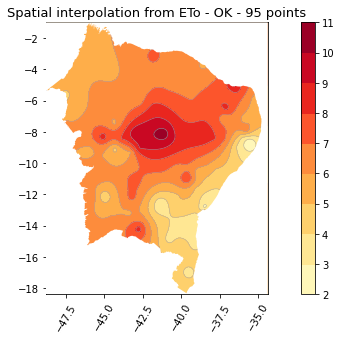

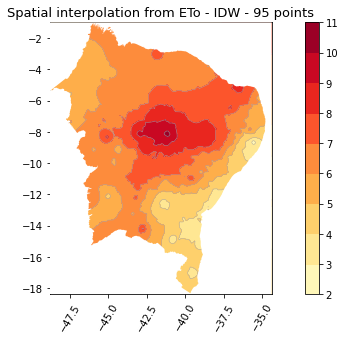

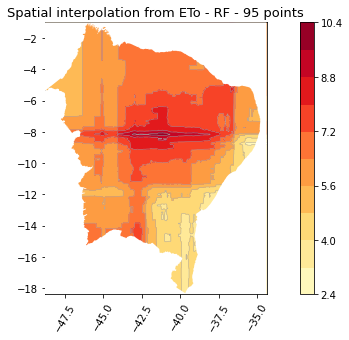

In [38]:
names = ['OK', 'IDW', 'RF']
for interp in names:
    y_pred = predict_eto(interp, X, y, df_coord[['VL_LONGITUDE', 'VL_LATITUDE']].values)
    plot_intepolation(interp, y_pred)
    print()